# SMAP soil moisture and GPM precipitation

## Author: Jacquelyn Witte

In [1]:
import os
from glob import glob

import datetime as dt
import earthpy as et
import h5py
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re
import seaborn as sns
import xarray as xr

import warnings
warnings.filterwarnings('ignore')

# Prettier plotting with seaborn
sns.set(font_scale=1.3)

In [2]:
def read_smap(filepath, index):
    """
    Reads SMAP data and returns the variable of interest.
    
    Parameters
    ----------
    filepath: Str
        File path of a SMAP L3 HDF5 file
        
    group_id: String
        Groups within the file to access
        
    index: int
        Index associated with the variable to retrieve
    
    Returns
    -------
    data: 2D numpy.ndarray (lat, lon)
    date: Date String yyyymmdd
    """
    # Read the file
    group_id = 'Soil_Moisture_Retrieval_Data_PM'
    with h5py.File(filepath, 'r') as f:
        # Extract data info
        data_id = list(f[group_id].keys())[index]
        data = f[group_id][data_id][:,:]
        data[data == f[group_id][data_id].attrs['_FillValue']] = np.nan
        
        filename = os.path.basename(filepath)
        yyyymmdd= filename.split('_')[5]
        yyyy = int(yyyymmdd[0:4])
        mm = int(yyyymmdd[4:6])
        dd = int(yyyymmdd[6:8])
        date=dt.datetime(yyyy,mm,dd)
    return data, date

In [3]:
def findfile(input_files, input_date):
    """
    Returns a single file from a list of files
    
    Parameters
    ----------
    input_files: List of strings
        List of full path to the file
        
    input_date: String
        YYYYMMDD format
        
    Returns
    -------
    file: Str
    """
    file = [x for x in input_files if re.findall(input_date, x)]
    if not file:
        raise ValueError('Date does not exist for '+input_date)
    return file

In [4]:
def nearestneighbor_ncdf(input_file, parameter, loc):
    """
    Extracts nearest neighbor value based on location and desired parameter. 
    
    Parameters
    ----------   
    input_file: Str - full path to a single file
    
    parameter: Str 
    
    loc: tuple (degree longtitude, degree latitude)
    
    Returns
    -------
    float
    """
    # read the netcdf file
    data_xr = xr.open_dataset(input_file).squeeze()
    
    # subset the file
    res = data_xr[parameter].sel(indexers={
            'lon': loc[0],
            'lat': loc[1]},
            method="nearest")
    return float(res.values)

#### Read and subset to Colorado Landslides >= year 2015 (SMAP data starts in 2015)

In [32]:
# Read the GLC file
glc_file = os.path.join(et.io.HOME,
                        'earth-analytics',
                        'data', 'capstone', 
                        'landslide', 'nasa_global_landslide_catalog_point.csv')

glc = pd.read_csv(glc_file)

glc_co = glc[(glc['country_code'] == 'US') & (
                glc['admin_division_name'] == 'Colorado') & (
                glc['landslide_trigger'] != 'freeze_thaw') & (
                glc['landslide_trigger'] != 'snowfall_snowmelt') & (
                glc['landslide_trigger'] != 'no_apparent_trigger') & (
                glc['landslide_trigger'] != 'other')              & (
                glc['landslide_trigger'] != 'unknown')
            ]
# convert to pandas datetime
glc_co['date'] = pd.to_datetime(glc_co['event_date'])
glc_co = glc_co.set_index('date').sort_index()
glc_co_gt2015 = glc_co[glc_co.index > '2015-04-01']

print(glc_co_gt2015.shape)
print(np.unique(glc_co_gt2015['landslide_trigger']))
print(glc_co_gt2015.columns)
#glc_co_gt2015.describe()

(39, 31)
['continuous_rain' 'downpour' 'rain']
Index(['OBJECTID', 'Shape', 'source_name', 'source_link', 'event_id',
       'event_date', 'event_time', 'event_title', 'event_description',
       'location_description', 'location_accuracy', 'landslide_category',
       'landslide_trigger', 'landslide_size', 'landslide_setting',
       'fatality_count', 'injury_count', 'storm_name', 'photo_link',
       'comments', 'event_import_source', 'event_import_id', 'latitude',
       'longitude', 'country_name', 'country_code', 'admin_division_name',
       'gazetteer_closest_point', 'gazetteer_distance', 'submitted_date',
       'last_edited_date'],
      dtype='object')


#### Get all SMAP, ESA and GPM data files, sorted
 - ESA = Percent of Saturation Soil Moisture
 - SMAP = Volumetric soil moisture in cm3/cm3
 - GPM = Precipitation accumulation in mm

In [36]:
data_dir = os.path.join(et.io.HOME,
                        'earth-analytics',
                        'data', 'capstone')
smap_files = sorted(glob(os.path.join(data_dir, 'smap_9km', '*.h5')))

gpm_files = sorted(glob(os.path.join(data_dir, 'gpm', '*nc4')))

esa_files = sorted(glob(os.path.join(data_dir, 'esa_soil_moisture', 
                                     '*ACTIVE*nc')))

# Print a sample as a sanity check
print(os.path.exists(smap_files[0]))
print(os.path.exists(gpm_files[0]))
print(os.path.exists(esa_files[0]))

True
True
True


#### These are SMAP variables that can provide key information in characterizing landslides over Colorado

| Variable Name | Index | Units |
| ----------- | ----------- | ----------- |
| soil_moisture | 24 | cm<sup>3</sup>/cm<sup>3</sup> |
| radar_water_body_fraction | 15 | N/A | 
| vegetation_opacity | 46 | N/A |
| vegetation_water_content | 50 | kg/m<sup>2</sup> |

#### Load the EASE2 grid lon and lat datasets to subset SMAP data. 
- These can be found on the NSIDC website: https://nsidc.org/data/ease/tools#geo_data_files

> Brodzik, M. J., B. Billingsley, T. Haran, B. Raup, M. H. Savoie. 2012. EASE-Grid 2.0: Incremental but Significant Improvements for Earth-Gridded Data Sets. ISPRS International Journal of Geo-Information, 1(1):32-45, doi:10.3390/ijgi1010032. http://www.mdpi.com/2220-9964/1/1/32.

In [7]:
# Reshape to dimensions of the SMAP data above
sm_data, date = read_smap(smap_files[1], 24)

lats = np.fromfile(os.path.join(data_dir, 'smap_9km',
                                'EASE2_M09km.lats.3856x1624x1.double'),
                   dtype=np.float64).reshape(sm_data.shape)
lons = np.fromfile(os.path.join(data_dir, 'smap_9km',
                                'EASE2_M09km.lons.3856x1624x1.double'),
                   dtype=np.float64).reshape(sm_data.shape)
sm_data.shape

(1624, 3856)

### Read the SMAP and GPM data 
- Colocated to all the Landslide events
- Collected measurements going back 7 day from each landslide event

In [41]:
sm_date = []
landslide_id = []
landslide_cat = []
landslide_trig = []
landslide_sz = []
lat = []
lon = []
periods = 7
count_down = []
sm_mean = []
sfct_mean = []
vegop_mean = []
vegwc_mean = []
precip = []
esa_sm = []

for i, ls_date in enumerate(glc_co_gt2015.index):
#for i, ls_date in enumerate(glc_co_gt2015.index[1:len(glc_co_gt2015.index)]):

    # Get -7 days from the event
    glc_date = pd.date_range(ls_date, periods=periods,
                             freq='-1D').strftime('%Y%m%d')

    countd = periods

    # Take the +/- 0.4 deg mean around the Landslide event
    N_lat = glc_co_gt2015.latitude[i]+0.2
    S_lat = glc_co_gt2015.latitude[i]-0.2
    W_lon = glc_co_gt2015.longitude[i]-0.2
    E_lon = glc_co_gt2015.longitude[i]+0.2
    subset = (lats < N_lat) & (lats > S_lat) & (lons > W_lon) & (lons < E_lon)

    #print(i, ls_date, glc_co_gt2015.latitude[i], glc_co_gt2015.longitude[i])
    
    # loop over the 7 days
    for yyyymmdd in glc_date:
        
        # Find the SMAP file
        filesm = findfile(smap_files, yyyymmdd)

        # Retrieve the SMAP variables
        sm, time_t = read_smap(filesm[0], 24)
        vegop, t = read_smap(filesm[0], 46)
        vegwc, t = read_smap(filesm[0], 50)
        # Calculate the SMAP mean
        sm_mean.append(np.nanmean(sm[subset]))
        vegop_mean.append(np.nanmean(vegop[subset]))
        vegwc_mean.append(np.nanmean(vegwc[subset]))

        # Append the date
        sm_date.append(yyyymmdd)

        # find the GPM file
        file_gpm = findfile(gpm_files, yyyymmdd) 

        # Get the nearest neighbor value of precipitation
        loc = (glc_co_gt2015.longitude[i], glc_co_gt2015.latitude[i])
        
        precip.append(nearestneighbor_ncdf(file_gpm[0], 
                             'precipitationCal', 
                             loc)
                     )
        
        # Find the ESA soil moisture file
        file_esa = findfile(esa_files, yyyymmdd) 

        # Get the nearest neighbor value of % soil moisture
        res_esa = nearestneighbor_ncdf(file_esa[0], 'sm', loc)
        # Replace negative values with NaN
        if res_esa < 0.0:
            esa_sm.append(np.nan)
        else:
            esa_sm.append(res_esa)

        # Append landslide metadata
        lat.append(glc_co_gt2015.latitude[i])
        lon.append(glc_co_gt2015.longitude[i])
        landslide_id.append(glc_co_gt2015.event_id[i])
        landslide_cat.append(glc_co_gt2015.landslide_category[i])
        landslide_trig.append(glc_co_gt2015.landslide_trigger[i])
        landslide_sz.append(glc_co_gt2015.landslide_size[i])

        # Append countdown
        count_down.append(countd)
        countd -= 1

# Create a pandas series
landslide_df = pd.DataFrame(sm_mean,
                            index=pd.to_datetime(sm_date), columns=['smap_sm'])
landslide_df['veg_opacity'] = vegop_mean
landslide_df['veg_water_content'] = vegwc_mean
landslide_df['precip_mm'] = precip
landslide_df['esa_sm_percent'] = esa_sm

# Add the Landslide metadata
landslide_df['glc_lat'] = lat
landslide_df['glc_lon'] = lon
landslide_df['landslide_id'] = landslide_id
landslide_df['landslide_category'] = landslide_cat
landslide_df['landslide_trigger'] = landslide_trig
landslide_df['landslide_size'] = landslide_sz
landslide_df['days-to-landslide'] = count_down

# Calculated the cumulative precipitation
accum = []
for i, data in landslide_df.groupby("landslide_id"):
    accum.extend(np.flip(data['precip_mm'].cumsum().values))
landslide_df['precip_accum_mm'] = accum

In [42]:
landslide_df.head()

,smap_sm,veg_opacity,veg_water_content,precip_mm,esa_sm_percent,glc_lat,glc_lon,landslide_id,landslide_category,landslide_trigger,landslide_size,days-to-landslide,precip_accum_mm
2015-04-27,0.237722,0.279058,3.957827,0.143790,69.368736,40.4802,-106.8393,6994,landslide,continuous_rain,medium,7,9.568942
2015-04-26,0.238028,0.237779,3.934495,0.068229,NaN,40.4802,-106.8393,6994,landslide,continuous_rain,medium,6,9.255543
2015-04-25,NaN,NaN,NaN,0.004842,54.474586,40.4802,-106.8393,6994,landslide,continuous_rain,medium,5,9.041108
2015-04-24,0.266953,0.242822,3.928329,0.022953,NaN,40.4802,-106.8393,6994,landslide,continuous_rain,medium,4,6.744161
2015-04-23,NaN,NaN,NaN,0.090758,55.441750,40.4802,-106.8393,6994,landslide,continuous_rain,medium,3,4.189932


### Plot soil time series going back 7 days from each co-located Landslide

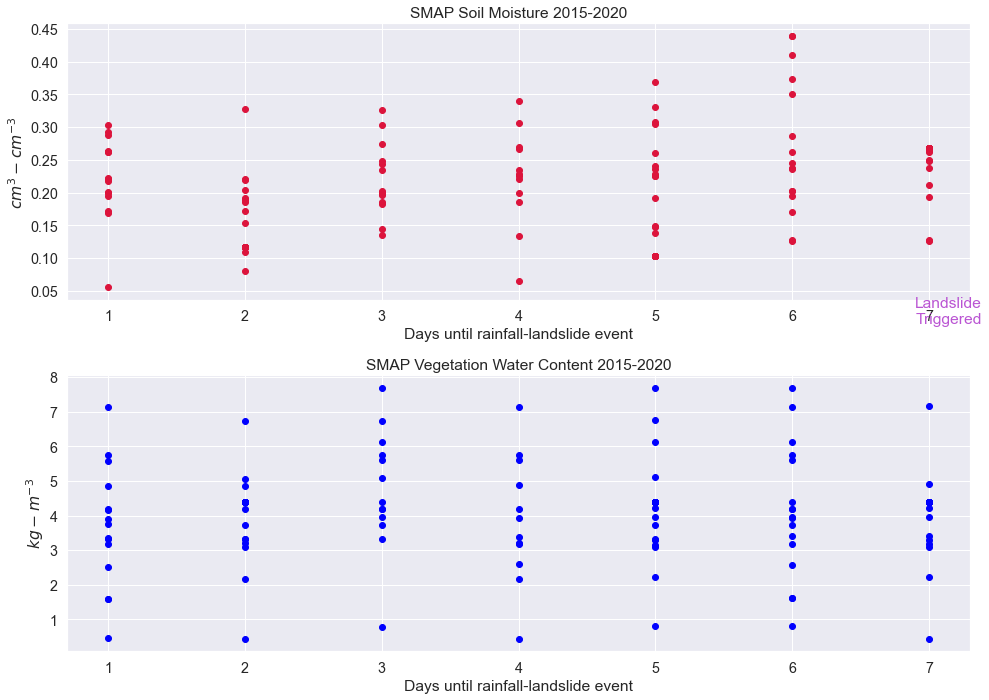

In [43]:
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(14, 10))

for id, df in landslide_df.groupby("landslide_id"):
    ax1.plot(df['days-to-landslide'], df['smap_sm'],
            marker='o', linestyle='none', color='crimson')

ax1.set(xlabel='Days until rainfall-landslide event',
       ylabel='$cm^3 - cm^{-3}$',
       title='SMAP Soil Moisture 2015-2020')

ax1.text(6.9, 0.0, 'Landslide\nTriggered', color='mediumorchid', fontsize='medium');

for id, df in landslide_df.groupby("landslide_id"):
    ax2.plot(df['days-to-landslide'], df['veg_water_content'],
            marker='o', linestyle='none', color='blue')

ax2.set(xlabel='Days until rainfall-landslide event',
       ylabel='$kg-m^{-3}$',
       title='SMAP Vegetation Water Content 2015-2020')

plt.tight_layout()
plt.savefig(os.path.join(et.io.HOME,
            'earth-analytics',
            'capstone-landslides-soilmoisture', 'plots',
            'smap_soilmoisture_timeseries.png'))

### Plot the cumulative precipitation going back 7 days

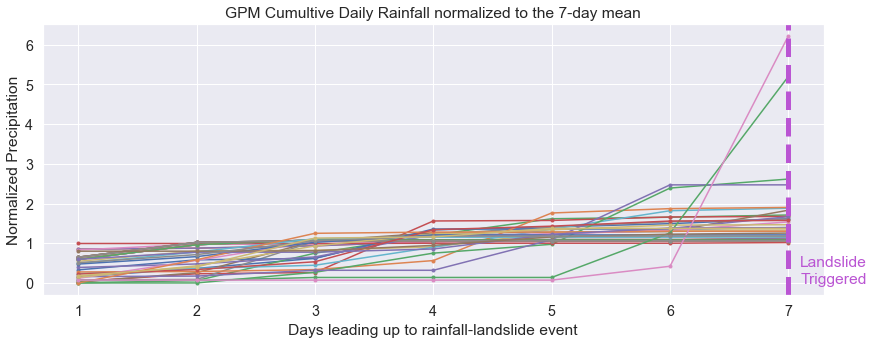

In [44]:
fig, ax = plt.subplots(figsize=(14, 5), sharex=True, sharey=True)

for id, df in landslide_df.groupby("landslide_id"):
    ax.plot(df['days-to-landslide'], 
            df['precip_accum_mm']/df['precip_accum_mm'].mean(), 
            marker='.')

#ax.invert_xaxis()
ax.axvline(x=7, ymin=0, color='mediumorchid', linestyle='dashed', linewidth=5)
#ax.set_xlim([-30,-0.5])
ax.set(xlabel='Days leading up to rainfall-landslide event',
       ylabel='Normalized Precipitation',
       title='GPM Cumultive Daily Rainfall normalized to the 7-day mean')
ax.text(7.1 ,0, 'Landslide\nTriggered', color='mediumorchid', fontsize='medium');

### Plot the ESA CCI Percent of Saturation Soil Moisture

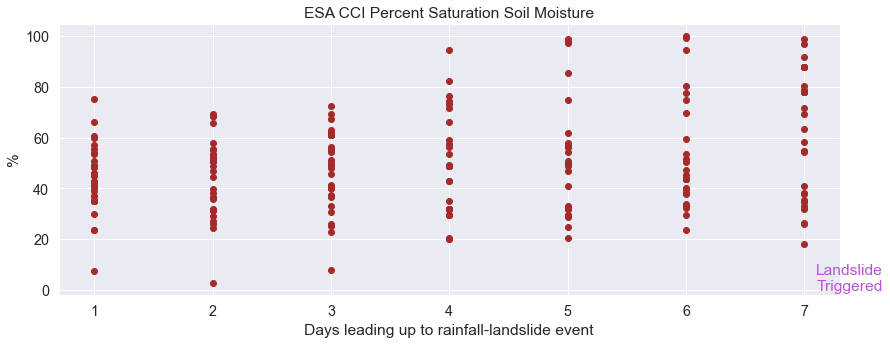

In [45]:
fig, ax = plt.subplots(figsize=(14, 5), sharex=True, sharey=True)

for id, df in landslide_df.groupby("landslide_id"):
    ax.plot(df['days-to-landslide'], df['esa_sm_percent'], 
            marker='o', linestyle='none', color='brown')

ax.set(xlabel='Days leading up to rainfall-landslide event',
       ylabel='%',
       title='ESA CCI Percent Saturation Soil Moisture')
ax.text(7.1 ,0, 'Landslide\nTriggered', color='mediumorchid', fontsize='medium');

### Plot Precipitation vs SMAP Soil Moisture

In [46]:
#category = np.unique(landslide_df['landslide_category'])
colors = ['red','green','orange','blue']

category = dict(zip(np.unique(landslide_df['landslide_category']), colors))
print(category)

trigger = dict(zip(np.unique(landslide_df['landslide_trigger']), colors))
print(trigger)

{'debris_flow': 'red', 'landslide': 'green', 'mudslide': 'orange', 'rock_fall': 'blue'}
{'continuous_rain': 'red', 'downpour': 'green', 'rain': 'orange'}


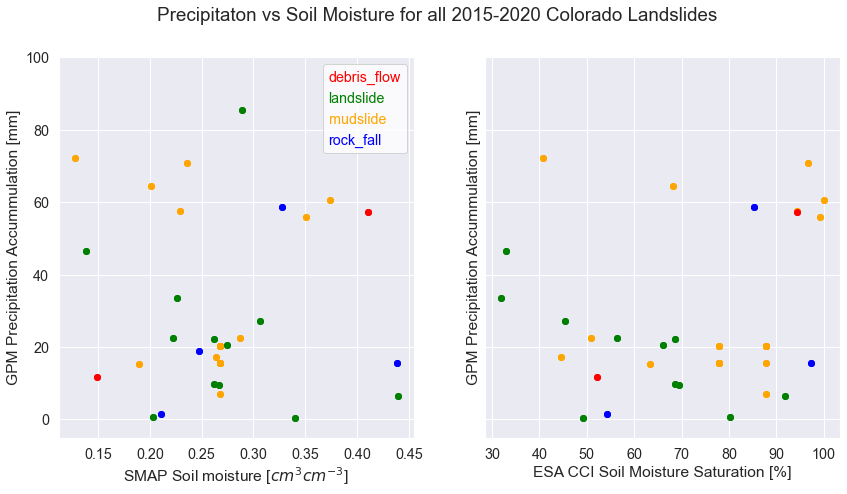

In [47]:
# Create a scatter plot
fig, (ax1, ax2) = plt.subplots(ncols=2, nrows=1, figsize=(14, 7),
                             sharey=True)

for id, df in landslide_df.groupby("landslide_id"):
    #res = df['precip_accum_mm']/df['precip_accum_mm'].mean()
    #if res.max() > 1.1:
    for cat in category:
        if df['landslide_category'][0] == cat:
            ax1.scatter(df['smap_sm'].max(), df['precip_accum_mm'].max(),
                   color=category[cat])
            ax2.scatter(df['esa_sm_percent'].max(), df['precip_accum_mm'].max(), 
                   color=category[cat])

ax1.set(xlabel='SMAP Soil moisture [$cm^3 cm^{-3}$]',
       ylabel='GPM Precipitation Accummulation [mm]')
ax1.set_ylim([-5, 100])

ax2.set(xlabel='ESA CCI Soil Moisture Saturation [%]',
       ylabel='GPM Precipitation Accummulation [mm]')
ax1.set_ylim([-5, 100]);

# Add legend
leg = ax1.legend(handlelength=0, handletextpad=0, fancybox=True,
               labels=category, labelcolor=colors, facecolor='white')
for item in leg.legendHandles:
    item.set_visible(False)
    
# add an overall caption
fig.suptitle(
    'Precipitaton vs Soil Moisture for all 2015-2020 Colorado Landslides'
);
    

for id, df in landslide_df.groupby("landslide_id"):
    #res = df['precip_accum_mm']/df['precip_accum_mm'].mean()
    #if res.max() > 1.1:
    for cat in category:
        if df['landslide_category'][0] == cat:
            ax1.scatter(df['smap_sm'].max(), df['precip_accum_mm'].max(),
                   color=category[cat])
            ax2.scatter(df['esa_sm_percent'].max(), df['precip_accum_mm'].max(), 
                   color=category[cat])

ax1.set(xlabel='SMAP Soil moisture [$cm^3 cm^{-3}$]',
       ylabel='GPM Precipitation Accummulation [mm]')
ax1.set_ylim([-5, 100])

ax2.set(xlabel='ESA CCI Soil Moisture Saturation [%]',
       ylabel='GPM Precipitation Accummulation [mm]')
ax1.set_ylim([-5, 100]);
    

# plt.savefig(os.path.join(et.io.HOME,
#             'earth-analytics',
#             'capstone-landslides-soilmoisture', 'plots',
#             'smap_VS_gpm_2015_2020.png'));

### Plot Precipitation vs ESA CCI Soil Moisture

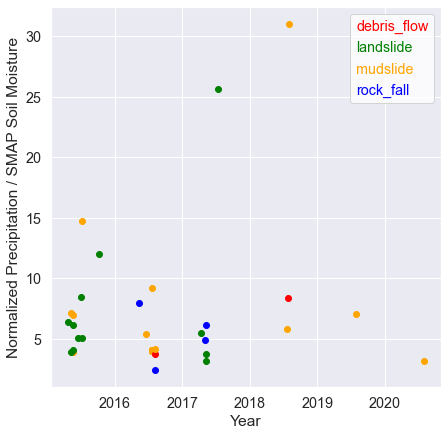

In [48]:
# Create a scatter plot
f, ax = plt.subplots(figsize=(7, 7))

count = 1
for id, df in landslide_df.groupby("landslide_id"):
    res = df['precip_accum_mm']/df['precip_accum_mm'].mean()
    #if res.max() > 1.1: 
    for cat in category:
        if df['landslide_category'][0] == cat:
            ax.scatter(df.index[0], res.max()/df['smap_sm'].max(),
                   color=category[cat])

    count=count+1

ax.set(xlabel='Year',
       ylabel='Normalized Precipitation / SMAP Soil Moisture');

# Add legend
leg = ax.legend(handlelength=0, handletextpad=0, fancybox=True,
               labels=category, labelcolor=colors, facecolor='white')
for item in leg.legendHandles:
    item.set_visible(False)
